# Deep convolutional generative adversarial networks

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim

In [2]:
PATH = "data/"
file_name = PATH + "mnist_train.csv"

In [3]:
df = pd.read_csv(file_name)

In [4]:
X = df.iloc[:, 1:].values
X = X.astype("float32")
scaler = MinMaxScaler(feature_range=(-1, 1))
X = scaler.fit_transform(X)
X = X.reshape((len(X), 1, 28, 28))
X.shape

(60000, 1, 28, 28)

In [5]:
batch_size = 128
seed = 42
device = "cuda"

In [6]:
class MnistDataset(Dataset):
    def __init__(self, X):
        self.X = torch.from_numpy(X).float().to(device)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx, :, :, :]

In [7]:
class BatchConvTranspose(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, padding=0):
        super().__init__()
        self.conv = nn.ConvTranspose2d(in_channels, out_channels, padding=padding,
                                       kernel_size=kernel_size, stride=2, bias=False)
        self.bn = nn.BatchNorm2d(out_channels)
        self.act = nn.ReLU()
        
    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.act(x)
        return x

class Generator(nn.Module):
    def __init__(self, z_dim):
        super().__init__()
        self.conv_1 = BatchConvTranspose(z_dim, int(z_dim / 2))
        self.conv_2 = BatchConvTranspose(int(z_dim / 2), int(z_dim / 4))
        self.conv_3 = BatchConvTranspose(int(z_dim / 4), int(z_dim / 8))
        
        self.conv_4 = nn.ConvTranspose2d(int(z_dim / 8), 1, padding=2, kernel_size=4, stride=2)
        self.act = nn.Tanh()
        
    def forward(self, x):
        x = self.conv_1(x)
        x = self.conv_2(x)
        x = self.conv_3(x)
        x = self.conv_4(x)
        x = self.act(x)
        return x

In [8]:
class BatchConv(nn.Module):
    def __init__(self, in_channels, out_channels, padding=0, kernel_size=3):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, padding=padding,
                              kernel_size=kernel_size, stride=2, bias=False)
        self.bn = nn.BatchNorm2d(out_channels)
        self.act = nn.LeakyReLU(0.2)
        
    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.act(x)
        return x

class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv_1 = BatchConv(1, 16)
        self.conv_2 = BatchConv(16, 32)
        self.conv_3 = BatchConv(32, 64)
        self.output_conv = nn.Conv2d(64, 1, kernel_size=2, stride=1)
        self.output_act = nn.Sigmoid()
        
    def forward(self, x):
        x = self.conv_1(x)
        x = self.conv_2(x)
        x = self.conv_3(x)
        x = self.output_conv(x)
        x = x.view((len(x), -1))
        x = self.output_act(x)
        return x

In [9]:
dataset = MnistDataset(X)
dataloader = DataLoader(dataset, batch_size=batch_size, num_workers=0)

In [10]:
z_dim = 128


torch.manual_seed(seed)
g_model = Generator(z_dim).to(device)
d_model = Discriminator().to(device)

In [11]:
lr = 2e-5
epochs = 200

fake_label = 0
real_label = 1

generator_optimizer = optim.Adam(g_model.parameters(), lr=lr, betas=(0.5, 0.999))
discriminator_optimizer = optim.Adam(d_model.parameters(), lr=lr, betas=(0.5, 0.999))

loss = nn.BCELoss()

In [12]:
g_loss_list = []
d_loss_list = []

np.random.seed(seed)
torch.manual_seed(seed)
g_model.train()
d_model.train()

for epoch in range(epochs):
    epoch_g_loss = 0.0
    epoch_d_loss = 0.0
    
    for (_, x) in enumerate(dataloader):
        # Discriminator part
        d_model.zero_grad()
        
        targets = torch.full((len(x), 1), real_label, device=device)
        p_real = d_model(x)
        d_loss_real = loss(p_real, targets)
        d_loss_real.backward()
        
        z = np.random.normal(0, 1, size=(len(x), z_dim, 1, 1))
        z = np.clip(z, -1, 1)
        
        z = torch.from_numpy(z).float().to(device)
        fake_img = g_model(z)
        
        p_fake = d_model(fake_img.detach())
        
        targets.fill_(fake_label)
        d_loss_fake = loss(p_fake, targets)
        d_loss_fake.backward()
        
        discriminator_optimizer.step()
        d_loss = d_loss_real + d_loss_fake
        epoch_d_loss += d_loss.detach().cpu().numpy()
        
        # Generator part
        g_model.zero_grad()
        p_fake = d_model(fake_img)
        
        # Note that we use real label here since we want to fool the discriminator
        targets.fill_(real_label)
        
        g_loss = loss(p_fake, targets)
        g_loss.backward()
        generator_optimizer.step()
        epoch_g_loss += g_loss.detach().cpu().numpy()
        
    d_loss_list.append(epoch_d_loss / len(dataloader))
    g_loss_list.append(epoch_g_loss / len(dataloader))
    
    if epoch % 10 == 0:
        print(f"------ Epoch {epoch} ------")
        print(f"Generator loss: {epoch_g_loss / len(dataloader)}")
        print(f"Discriminator loss: {epoch_d_loss / len(dataloader)}")

------ Epoch 0 ------
Generator loss: 0.689667101734991
Discriminator loss: 1.206129604056954
------ Epoch 10 ------
Generator loss: 1.7178025327003332
Discriminator loss: 0.48382319741920116
------ Epoch 20 ------
Generator loss: 2.8308282739826356
Discriminator loss: 0.22894775276499263
------ Epoch 30 ------
Generator loss: 2.5699033954504458
Discriminator loss: 0.29630916227282744
------ Epoch 40 ------
Generator loss: 2.2201069889546456
Discriminator loss: 0.3920432270717011
------ Epoch 50 ------
Generator loss: 2.005337435045222
Discriminator loss: 0.4793519470800977
------ Epoch 60 ------
Generator loss: 1.8340925016382863
Discriminator loss: 0.5479286297170847
------ Epoch 70 ------
Generator loss: 1.7585174391772955
Discriminator loss: 0.5799492639519258
------ Epoch 80 ------
Generator loss: 1.7354860797619769
Discriminator loss: 0.6008339178587582
------ Epoch 90 ------
Generator loss: 1.7385175977942786
Discriminator loss: 0.5952290864641478
------ Epoch 100 ------
Generat

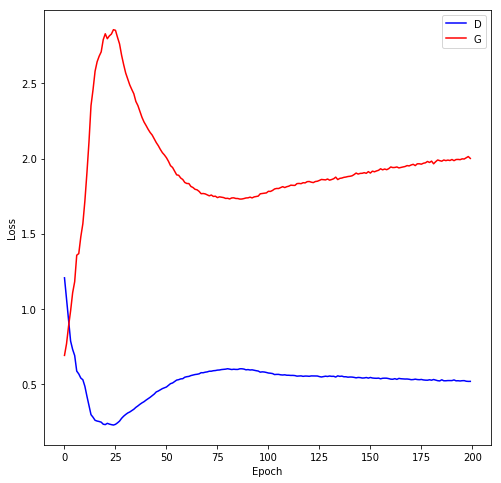

In [13]:
plt.figure(figsize=(8, 8))
plt.plot(d_loss_list, "b", label="D")
plt.plot(g_loss_list, "r", label="G")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [14]:
np.random.seed(seed)
g_model.eval()

z = np.random.normal(0, 1, size=(9, z_dim, 1, 1))
z = np.clip(z, -1, 1)
z = torch.from_numpy(z).float().to(device)
img_fake = g_model(z)
img_fake = img_fake[:, 0, :, :].detach().cpu().numpy()

img_fake = (img_fake + 1) * 255 / 2
img_fake = np.round(img_fake)

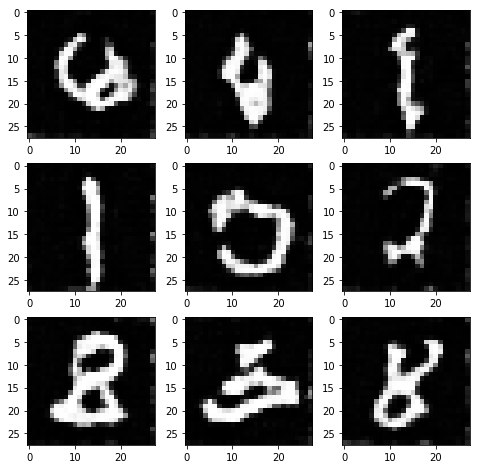

In [15]:
# Fake images
fig, ax = plt.subplots(3, 3, figsize=(8, 8))

for i in range(3):
    for j in range(3):
        ax[i, j].imshow(img_fake[i*3 + j, :, :], cmap="gray")
plt.show()

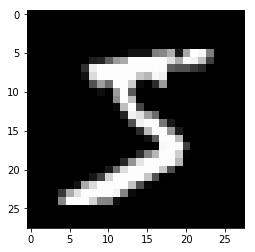

In [16]:
# Real image
plt.imshow(X[0, :].reshape(28, 28), cmap="gray")
plt.show()